In [1]:
# Fix for OpenMP runtime error on Windows
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import pickle
import os
import sys

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
    USE_CUDA = True
else:
    DEVICE='cpu'
    USE_CUDA = False

from typing import Optional, Tuple
from tqdm.notebook import tqdm

In [3]:
# colab dgm_utils install
COMMIT_HASH = "f248183c31ac030c81031ae2d2f1a1c42e3a197b"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

-d was unexpected at this time.


e:\nau\ML_courses_GenAI_NLP\scientificProject\GenAI\sem5_vae\dgm_utils


fatal: destination path 'dgm_utils' already exists and is not an empty directory.
HEAD is now at f248183 Merge pull request #2 from fasSstem/main


Defaulting to user installation because normal site-packages is not writeable
Processing e:\nau\ml_courses_genai_nlp\scientificproject\genai\sem5_vae\dgm_utils
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dgm-utils: filename=dgm_utils-0.1.0-py3-none-any.whl size=5124 sha256=5236dd8f7f987766db250e75ecc32ba316571242fee7c6a3be9dfa2c425340b9
  Stored in directory: C:\Users\twoli\AppData\Local\Temp\pip-ephem-wheel-cache-emk6rpm_\wheels\d9\bd\e3\e049cb1fe1c9e52a8c129eed50919c8eb8ffb228ccfc6bfb0f
Successfully built dgm-utils
  Attempting uninstall: dgm-utils
    Found existing installation: dgm-utils 0.1.0
    Uninstalling dgm-utils-0.1.0:
      Successfully uninstalled dgm-utils-0.1.0
e:\nau\ML_courses_GenAI_NLP\scientificProject\GenAI\sem5_vae


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
from dgm_utils import train_model, plot_training_curves, BaseModel
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_dataset

In [5]:
def generate_2d_data(
    count: int, mode: str = "univariate"
) -> Tuple[np.ndarray, np.ndarray]:
    assert mode in ["univariate", "multivariate"]
    np.random.seed(42)
    mean = [[2.0, 3.0]]
    sigma = [[3.0, 1.0]]
    if mode == "univariate":
        rotate = [[1.0, 0.0], [0.0, 1.0]]
    else:
        rotate = [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]]
    data = mean + (np.random.randn(count, 2) * sigma).dot(rotate)
    data = data.astype("float32")
    split = int(0.7 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

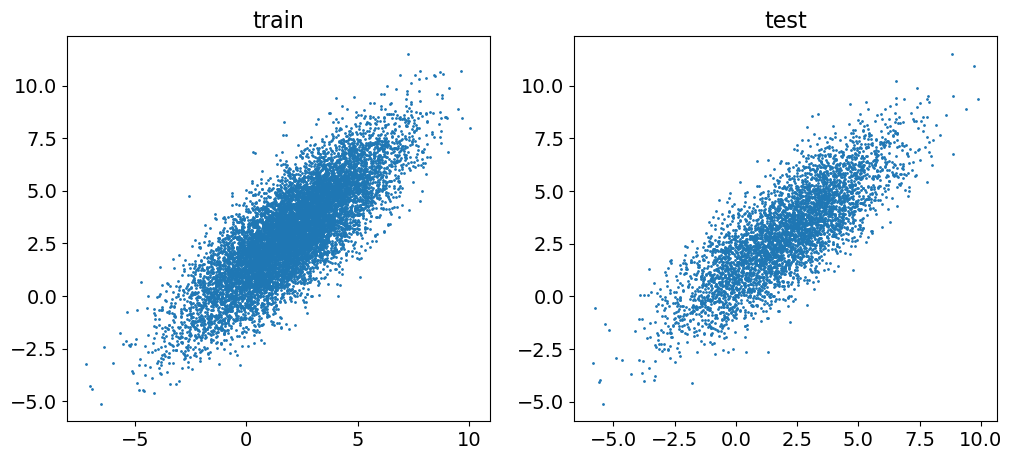

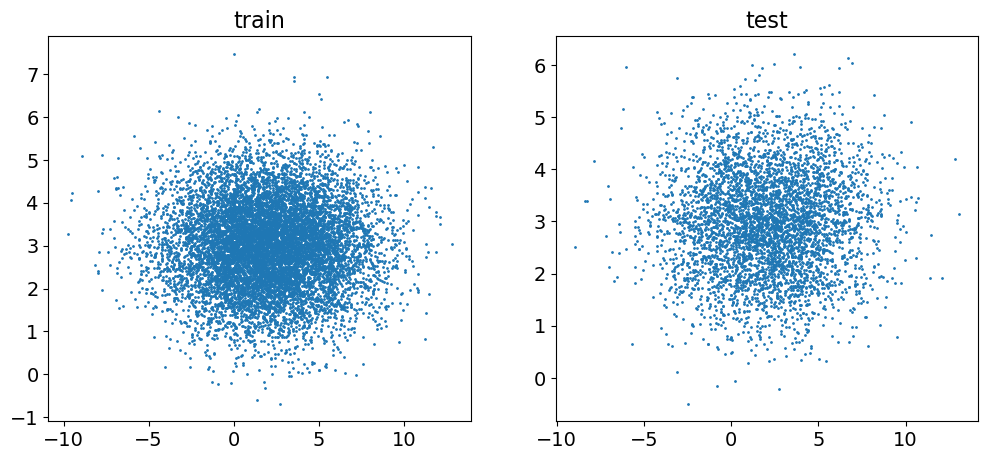

In [6]:
COUNT = 15000

train_data, test_data = generate_2d_data(COUNT, mode="multivariate")
visualize_2d_data(train_data, test_data)

train_data, test_data = generate_2d_data(COUNT, mode="univariate")
visualize_2d_data(train_data, test_data)

In [ ]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """

    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    
    # KL divergence formula for normal distributions with diagonal covariance:
    # KL(p1 || p2) = 0.5 * Σ[log(σ₂²/σ₁²) + σ₁²/σ₂² + (μ₁ - μ₂)²/σ₂² - 1]
    
    # Convert log_std to std (standard deviation)
    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)
    
    # Calculate KL divergence term by term
    # log(σ₂²/σ₁²) = 2*log(σ₂) - 2*log(σ₁) = 2*log_std_2 - 2*log_std_1
    log_ratio = 2 * (log_std_2 - log_std_1)
    
    # σ₁²/σ₂² = (std_1/std_2)²
    var_ratio = (std_1 / std_2) ** 2
    
    # (μ₁ - μ₂)²/σ₂² = (mean_1 - mean_2)² / std_2²
    mean_diff_squared = (mean_1 - mean_2) ** 2 / (std_2 ** 2)
    
    # Combine all terms: 0.5 * (log_ratio + var_ratio + mean_diff_squared - 1)
    kl_divergence = (log_ratio + var_ratio + mean_diff_squared - 1)
    
    # Sum over all dimensions
    return 0.5 * kl_divergence


def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    
    std_sq = log_std.exp()**2
    term1 = (x - mean) ** 2 / std_sq
    term2 = torch.log( torch.tensor(2 * torch.pi) * std_sq)
    nll = 0.5 * (term1 + term2)
    return nll